In [15]:
# ==========================
# Waste-to-Energy Prediction Pipeline with Ensembles
# ==========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from statsmodels.tsa.statespace.sarimax import SARIMAX
import joblib
import os



In [16]:
# ---------------------------
# Load Dataset
# ---------------------------
df = pd.read_csv("mumbai_msw_data_2020_2024 (2).csv")

print("Columns after reading CSV:", df.columns)
print(f"Loaded {df.shape[0]} rows, columns: {list(df.columns)}")

# Define target
target_col = "Estimated Energy Output (MWh)"

# Drop leakage-prone or non-predictive columns
drop_cols = ["Month-Year", "adj_lhv", "dry_fraction"]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

X = df.drop(columns=[target_col])
y = df[target_col]

Columns after reading CSV: Index(['Month-Year', 'Waste Quantity (tons/day)',
       'Waste Quantity (tons/month)', 'Organics (%)', 'Plastics (%)',
       'Paper (%)', 'Textiles (%)', 'Glass (%)', 'Metals (%)', 'Inerts (%)',
       'Moisture Content (%)', 'Average Calorific Value (MJ/kg)',
       'Estimated Energy Output (MWh)'],
      dtype='object')
Loaded 60 rows, columns: ['Month-Year', 'Waste Quantity (tons/day)', 'Waste Quantity (tons/month)', 'Organics (%)', 'Plastics (%)', 'Paper (%)', 'Textiles (%)', 'Glass (%)', 'Metals (%)', 'Inerts (%)', 'Moisture Content (%)', 'Average Calorific Value (MJ/kg)', 'Estimated Energy Output (MWh)']


In [17]:
# ---------------------------
# Correlation check
# ---------------------------
corrs = X.corrwith(y).sort_values(ascending=False)
print("\nWarning: extremely high correlation detected between target and features (possible leakage):")
print(corrs[abs(corrs) > 0.95])




Series([], dtype: float64)


In [18]:
# ---------------------------
# Train / Validation / Test Split
# ---------------------------
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.175, shuffle=False)

print(f"\nData split -> train: {len(X_train)}, val: {len(X_val)}, test: {len(X_test)}")




Data split -> train: 42, val: 9, test: 9


In [19]:
# ---------------------------
# Helper functions
# ---------------------------
def evaluate(model, X_val, y_val, model_name):
    preds = model.predict(X_val)
    return {
        "Model": model_name,
        "R2": r2_score(y_val, preds),
        "RMSE": np.sqrt(mean_squared_error(y_val, preds)),
        "MAE": mean_absolute_error(y_val, preds),
        "MAPE": np.mean(np.abs((y_val - preds) / y_val)) * 100
    }, preds

def evaluate_array(preds, y_true, name):
    return {
        "Model": name,
        "R2": r2_score(y_true, preds),
        "RMSE": np.sqrt(mean_squared_error(y_true, preds)),
        "MAE": mean_absolute_error(y_true, preds),
        "MAPE": np.mean(np.abs((y_true - preds) / y_true)) * 100
    }

results, val_preds = [], {}



In [20]:
# ---------------------------
# Linear Regression
# ---------------------------
lr = LinearRegression().fit(X_train, y_train)
res, preds = evaluate(lr, X_val, y_val, "LinearRegression")
results.append(res); val_preds["LinearRegression"] = preds



In [21]:
# ---------------------------
# Random Forest
# ---------------------------
rf = RandomForestRegressor(n_estimators=200, random_state=42).fit(X_train, y_train)
res, preds = evaluate(rf, X_val, y_val, "RandomForest_Tuned")
results.append(res); val_preds["RandomForest"] = preds

# ---------------------------
# XGBoost
# ---------------------------
xgb = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=4, subsample=0.8, random_state=42)
xgb.fit(X_train, y_train)
res, preds = evaluate(xgb, X_val, y_val, "XGBoost")
results.append(res); val_preds["XGBoost"] = preds

# ---------------------------
# ANN
# ---------------------------
ann = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]),
    Dense(32, activation='relu'),
    Dense(1)
])
ann.compile(optimizer=Adam(0.01), loss='mse')
ann.fit(X_train, y_train, epochs=100, batch_size=8, verbose=0)
preds = ann.predict(X_val).ravel()
res = {
    "Model": "ANN",
    "R2": r2_score(y_val, preds),
    "RMSE": np.sqrt(mean_squared_error(y_val, preds)),
    "MAE": mean_absolute_error(y_val, preds),
    "MAPE": np.mean(np.abs((y_val - preds) / y_val)) * 100
}
results.append(res); val_preds["ANN"] = preds

# ---------------------------
# SARIMAX (time-series)
# ---------------------------
# Fit on trainval to respect temporal ordering; forecast purely on len(y_val)
sarimax = SARIMAX(y_trainval, order=(1,1,1), seasonal_order=(1,1,1,12))
sarimax_fit = sarimax.fit(disp=False)
sarimax_preds = sarimax_fit.forecast(len(y_val)).values  # convert to np.array for consistency
res = {
    "Model": "SARIMAX",
    "R2": r2_score(y_val, sarimax_preds),
    "RMSE": np.sqrt(mean_squared_error(y_val, sarimax_preds)),
    "MAE": mean_absolute_error(y_val, sarimax_preds),
    "MAPE": np.mean(np.abs((y_val - sarimax_preds) / y_val)) * 100
}
results.append(res); val_preds["SARIMAX"] = sarimax_preds



C:\Users\sawan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


C:\Users\sawan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [22]:
# ---------------------------
# Results Summary
# ---------------------------
res_df = pd.DataFrame(results)
print("\n=== Validation Performance Summary ===\n")
print(res_df)




=== Validation Performance Summary ===

                Model        R2          RMSE          MAE       MAPE
0    LinearRegression  0.992682    603.527586   515.440841   1.100751
1  RandomForest_Tuned  0.514999   4913.285381  4112.177778   7.948989
2             XGBoost  0.714799   3767.696511  2845.791992   5.447005
3                 ANN  0.155216   6484.453408  5388.937988  12.031409
4             SARIMAX -1.068266  10146.210874  8342.795027  19.105172


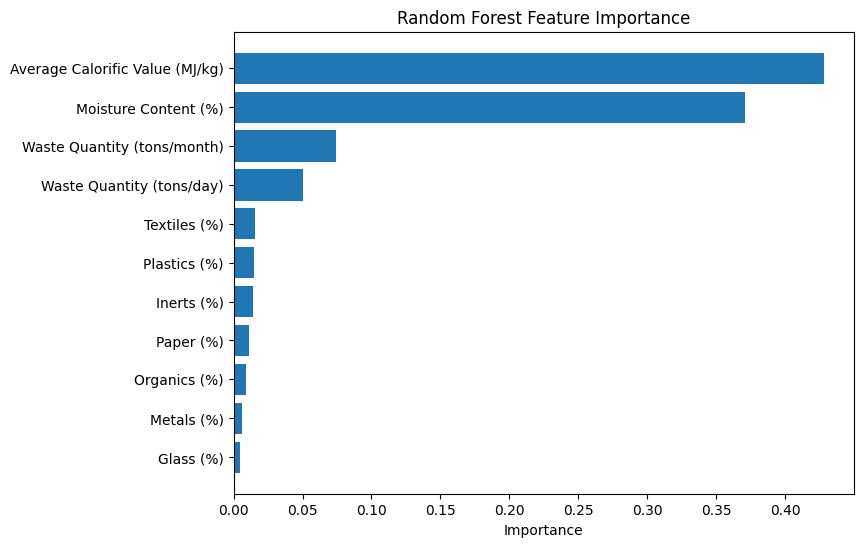

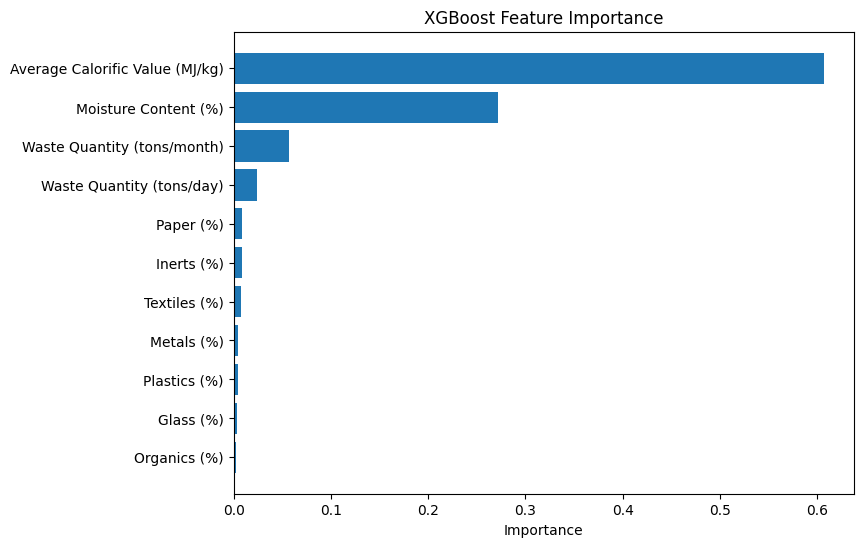

In [23]:
# ---------------------------
# Feature Importance
# ---------------------------
def plot_feature_importance(model, X, title):
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        sorted_idx = np.argsort(importances)
        plt.figure(figsize=(8,6))
        plt.barh(range(len(sorted_idx)), importances[sorted_idx], align="center")
        plt.yticks(range(len(sorted_idx)), [X.columns[i] for i in sorted_idx])
        plt.title(title)
        plt.xlabel("Importance")
        plt.show()

plot_feature_importance(rf, X, "Random Forest Feature Importance")
plot_feature_importance(xgb, X, "XGBoost Feature Importance")



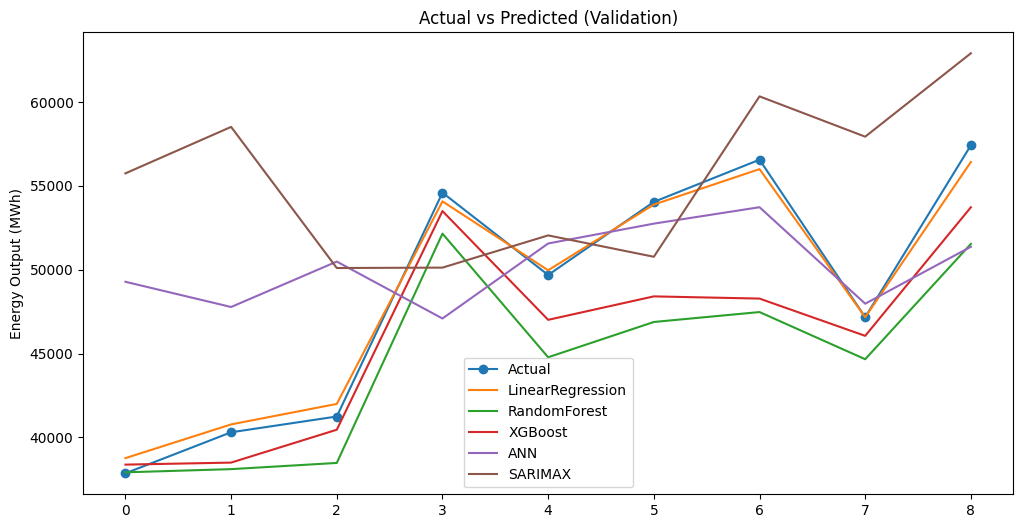

In [24]:
# ---------------------------
# Actual vs Predicted (Validation)
# ---------------------------
plt.figure(figsize=(12,6))
plt.plot(y_val.values, label="Actual", marker="o")
for model_name, preds in val_preds.items():
    plt.plot(preds, label=model_name)
plt.legend()
plt.title("Actual vs Predicted (Validation)")
plt.ylabel("Energy Output (MWh)")
plt.show()



In [25]:
# ===========================================================
# Ensemble Utilities
# ===========================================================
BASE_MODELS = ["LinearRegression", "RandomForest", "XGBoost", "ANN", "SARIMAX"]

def stack_val_matrix(val_preds_dict, base_models=BASE_MODELS):
    """Construct validation prediction matrix of shape (n_samples, n_models)."""
    return np.column_stack([val_preds_dict[m if m != "RandomForest" else "RandomForest"] for m in base_models])

def simple_average(val_preds_dict, base_models=BASE_MODELS):
    P = stack_val_matrix(val_preds_dict, base_models)
    return np.mean(P, axis=1)

def performance_weights(res_df, base_models=BASE_MODELS, metric="RMSE"):
    """Compute weights inversely proportional to metric; robust to extreme values."""
    df = res_df.set_index("Model")
    # Map model names used in results to our BASE_MODELS keys
    name_map = {
        "LinearRegression":"LinearRegression",
        "RandomForest_Tuned":"RandomForest",
        "XGBoost":"XGBoost",
        "ANN":"ANN",
        "SARIMAX":"SARIMAX"
    }
    metrics = []
    for m in base_models:
        row_name = [k for k,v in name_map.items() if v == m][0]
        metrics.append(df.loc[row_name, metric])
    metrics = np.array(metrics, dtype=float)
    # Stabilize inverse with epsilon
    eps = 1e-8
    inv = 1.0 / (metrics + eps)
    w = inv / inv.sum()
    return w  # shape (n_models,)

def weighted_average(val_preds_dict, weights, base_models=BASE_MODELS):
    P = stack_val_matrix(val_preds_dict, base_models)
    return P @ weights

def stacking_fit(P_val, y_val, alpha=1.0):
    """Fit a simple ridge meta-model on validation predictions."""
    meta = Ridge(alpha=alpha, random_state=42)
    meta.fit(P_val, y_val)
    return meta

def ensemble_uncertainty(val_preds_dict, base_models=BASE_MODELS):
    """Estimate ensemble predictive variance across base models (epistemic proxy)."""
    P = stack_val_matrix(val_preds_dict, base_models)
    return P.var(axis=1)




=== Ensemble Validation Performance ===

                     Model        R2         RMSE          MAE      MAPE
0       Ensemble_SimpleAvg  0.757039  3477.513514  3131.201034  6.834321
1  Ensemble_WeightedByRMSE  0.956361  1473.797237  1311.588329  2.741084
2   Ensemble_StackingRidge  0.999871    80.025940    65.965501  0.138730


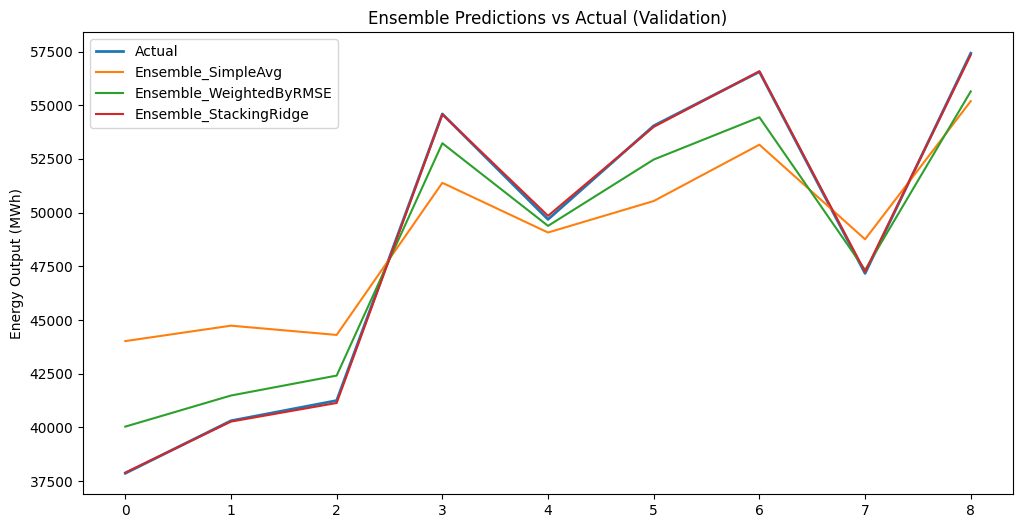

In [26]:
# ---------------------------
# Build Ensembles on Validation
# ---------------------------
P_val = stack_val_matrix(val_preds, BASE_MODELS)
simple_avg_preds = simple_average(val_preds, BASE_MODELS)
w_rmse = performance_weights(res_df, BASE_MODELS, metric="RMSE")
weighted_preds = weighted_average(val_preds, w_rmse, BASE_MODELS)
meta_model = stacking_fit(P_val, y_val, alpha=1.0)
stack_preds = meta_model.predict(P_val)
val_var = ensemble_uncertainty(val_preds, BASE_MODELS)

# Evaluate ensembles
ens_results = []
ens_results.append(evaluate_array(simple_avg_preds, y_val, "Ensemble_SimpleAvg"))
ens_results.append(evaluate_array(weighted_preds, y_val, "Ensemble_WeightedByRMSE"))
ens_results.append(evaluate_array(stack_preds, y_val, "Ensemble_StackingRidge"))

ens_df = pd.DataFrame(ens_results)
print("\n=== Ensemble Validation Performance ===\n")
print(ens_df)

# Plot ensembles vs actual
plt.figure(figsize=(12,6))
plt.plot(y_val.values, label="Actual", linewidth=2)
plt.plot(simple_avg_preds, label="Ensemble_SimpleAvg")
plt.plot(weighted_preds, label="Ensemble_WeightedByRMSE")
plt.plot(stack_preds, label="Ensemble_StackingRidge")
plt.legend()
plt.title("Ensemble Predictions vs Actual (Validation)")
plt.ylabel("Energy Output (MWh)")
plt.show()



In [27]:
# ---------------------------
# Fit base models on full trainval for test evaluation
# ---------------------------
# Refit base models to trainval to avoid validation bleed when going to test
lr_full = LinearRegression().fit(X_trainval, y_trainval)
rf_full = RandomForestRegressor(n_estimators=200, random_state=42).fit(X_trainval, y_trainval)
xgb_full = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=4, subsample=0.8, random_state=42)
xgb_full.fit(X_trainval, y_trainval)

ann_full = Sequential([
    Dense(64, activation='relu', input_dim=X_trainval.shape[1]),
    Dense(32, activation='relu'),
    Dense(1)
])
ann_full.compile(optimizer=Adam(0.01), loss='mse')
ann_full.fit(X_trainval, y_trainval, epochs=100, batch_size=8, verbose=0)

# SARIMAX already fit on trainval; need to forecast len(test)
sarimax_test_preds = sarimax_fit.forecast(len(y_test)).values

# Collect test predictions
test_preds = {
    "LinearRegression": lr_full.predict(X_test),
    "RandomForest": rf_full.predict(X_test),
    "XGBoost": xgb_full.predict(X_test),
    "ANN": ann_full.predict(X_test).ravel(),
    "SARIMAX": sarimax_test_preds
}

# Build test ensemble predictions using validation-derived weights/meta-model
P_test = np.column_stack([test_preds[m] for m in BASE_MODELS])
simple_avg_test = np.mean(P_test, axis=1)
weighted_test = P_test @ w_rmse  # use same weights from validation RMSE
stack_test = meta_model.predict(P_test)

# Evaluate on test
def eval_and_print(name, preds, y_true):
    r = {
        "Model": name,
        "R2": r2_score(y_true, preds),
        "RMSE": np.sqrt(mean_squared_error(y_true, preds)),
        "MAE": mean_absolute_error(y_true, preds),
        "MAPE": np.mean(np.abs((y_true - preds) / y_true)) * 100
    }
    print(f"{name} -> R2: {r['R2']:.4f}, RMSE: {r['RMSE']:.4f}, MAE: {r['MAE']:.4f}, MAPE: {r['MAPE']:.2f}%")
    return r

print("\n=== Test Performance (Base Models) ===")
test_base_results = []
for name, preds in test_preds.items():
    test_base_results.append(eval_and_print(name, preds, y_test))

print("\n=== Test Performance (Ensembles) ===")
test_ens_results = []
test_ens_results.append(eval_and_print("Ensemble_SimpleAvg", simple_avg_test, y_test))
test_ens_results.append(eval_and_print("Ensemble_WeightedByRMSE", weighted_test, y_test))
test_ens_results.append(eval_and_print("Ensemble_StackingRidge", stack_test, y_test))



C:\Users\sawan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

=== Test Performance (Base Models) ===
LinearRegression -> R2: 0.9753, RMSE: 787.0511, MAE: 683.5236, MAPE: 1.60%
RandomForest -> R2: 0.7142, RMSE: 2679.4853, MAE: 1845.8389, MAPE: 3.92%
XGBoost -> R2: 0.7799, RMSE: 2351.4148, MAE: 1664.0768, MAPE: 3.64%
ANN -> R2: -1.8421, RMSE: 8449.1974, MAE: 7418.4541, MAPE: 17.45%
SARIMAX -> R2: -3.5318, RMSE: 10669.2631, MAE: 10103.0976, MAPE: 22.95%

=== Test Performance (Ensembles) ===
Ensemble_SimpleAvg -> R2: 0.4705, RMSE: 3646.8660, MAE: 3152.5497, MAPE: 7.49%
Ensemble_WeightedByRMSE -> R2: 0.9178, RMSE: 1436.8700, MAE: 1177.6327, MAPE: 2.83%
Ensemble_StackingRidge -> R2: 0.9937, RMSE: 397.3073, MAE: 340.8260, MAPE: 0.74%


In [28]:
# ---------------------------
# Save models and ensembles
# ---------------------------
if not os.path.exists("./models"):
    os.makedirs("./models")

joblib.dump(lr, "./models/linear.pkl")
joblib.dump(rf, "./models/rf.pkl")
joblib.dump(xgb, "./models/xgb.pkl")
ann.save("./models/ann.h5")
sarimax_fit.save("./models/sarimax.pkl")

# Save refit models used for test-time inference
joblib.dump(lr_full, "./models/linear_full.pkl")
joblib.dump(rf_full, "./models/rf_full.pkl")
joblib.dump(xgb_full, "./models/xgb_full.pkl")
ann_full.save("./models/ann_full.h5")

# Save ensemble artifacts
np.save("./models/ensemble_weights_rmse.npy", w_rmse)
joblib.dump(meta_model, "./models/stacking_ridge.pkl")

print("\nSaved trained models and ensemble artifacts in ./models/")


Saved trained models and ensemble artifacts in ./models/
